Importamos las librerías necesarias 

In [62]:
from pymongo import MongoClient
import pandas as pd
import seaborn as sns
import json
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from scipy.interpolate import make_interp_spline
from dotenv import load_dotenv
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')


Establecemos la conexión con la base de datos en MongoDB

In [63]:
# Cargar el archivo .env.mongo_credentials
load_dotenv(dotenv_path='.env.mongo_credentials')

# Obtener la URI de MongoDB desde la variable de entorno
mongo_uri = os.getenv("MONGO_URI")

# Usar la URI para conectar a MongoDB
from pymongo import MongoClient
client = MongoClient(mongo_uri)

# Seleccionar la base de datos
db = client["test"]

# Seleccionar la colección
collection1 = db["users"]
collection2 = db["appointments"]

# Prueba: Insertar un documento de ejemplo
#doc = {"name": "John Doe", "age": 30, "email": "johndoe@example.com"}
#result = collection.insert_one(doc)
#print(f"Documento insertado con ID: {result.inserted_id}")

Listamos los documentos contenidos dentro de las colecciones

In [64]:
# Listar los primeros 15 documentos
user_documents = collection1.find().limit(3)

# Iterar y mostrar cada documento
#for doc in user_documents:
    #print(doc)



Convertimos el dataset en un dataframe de pandas para su procesamiento

In [65]:
# Obtener todos los documentos de la colección
user_documents = list(collection1.find())

# Convertir los documentos a un DataFrame
df_users = pd.DataFrame(user_documents)

# Ver los primeros registros del DataFrame
#df_users.head()


In [66]:
# Listar todos los contactos
appointments = collection2.find()

# Iterar y mostrar cada documento
#for doc in appointments:
    #print(doc)

In [67]:
# Obtener todos los documentos de la colección
appointments = list(collection2.find())

# Convertir los documentos a un DataFrame
df_appointments = pd.DataFrame(appointments)

In [68]:
# Eliminar columnas no relevantes

#df_users = df_users.drop(["_id"], axis=1)

In [69]:
# Convertir columnas de tiempo a formato datetime

df_users["createdAt"] = pd.to_datetime(df_users["createdAt"], errors="coerce")
df_users["updatedAt"] = pd.to_datetime(df_users["updatedAt"], errors="coerce")

In [70]:
df_users.dtypes

_id                              object
name                             object
type                             object
given_name                       object
family_name                      object
primary_email_address            object
state                            object
credential                       object
clinics                          object
addresses                        object
phone_numbers                    object
email_addresses                  object
createdAt                datetime64[ns]
updatedAt                datetime64[ns]
__v                               int64
birth_date                       object
gender                           object
notes                            object
primary_phone_number             object
dtype: object

In [71]:
#Resumen de tendencias centrales del dataset

df_users.describe()

,createdAt,updatedAt,__v
count,95,95,95.0
mean,2025-01-14 02:44:46.209936640,2025-01-14 02:48:11.529000192,0.0
min,2025-01-14 02:41:25.015000,2025-01-14 02:48:03.138000,0.0
25%,2025-01-14 02:42:55.398500096,2025-01-14 02:48:07.760000,0.0
50%,2025-01-14 02:44:51.772999936,2025-01-14 02:48:11.628999936,0.0
75%,2025-01-14 02:46:25.025999872,2025-01-14 02:48:15.477499904,0.0
max,2025-01-14 02:48:02.838000,2025-01-14 02:48:19.400000,0.0
std,NaN,NaN,0.0


In [72]:
# Ver valores nulos por columna

print(df_users.isnull().sum())


_id                      0
name                     0
type                     0
given_name               0
family_name              0
primary_email_address    0
state                    0
credential               0
clinics                  0
addresses                0
phone_numbers            0
email_addresses          0
createdAt                0
updatedAt                0
__v                      0
birth_date               0
gender                   0
notes                    0
primary_phone_number     0
dtype: int64


Visualización gráfica de la distribución porcentual de géneros de los pacientes

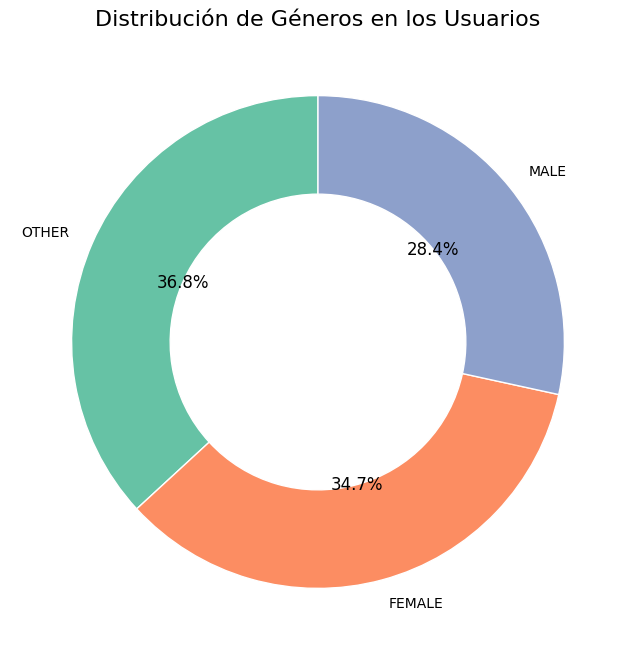

In [73]:
df_users['gender'] = df_users['gender'].astype('category')

# Calcular la distribución porcentual
gender_distribution = df_users['gender'].value_counts(normalize=True) * 100

# Crear un gráfico de torta con un agujero en el centro (donut)
plt.figure(figsize=(8, 8))  # Tamaño del gráfico
wedges, texts, autotexts = plt.pie(
    gender_distribution.values,  # Valores porcentuales
    labels=gender_distribution.index,  # Etiquetas de los géneros
    autopct='%1.1f%%',  # Mostrar porcentajes en cada sección
    startangle=90,  # Rotación para que el primer sector empiece arriba
    colors=plt.cm.Set2.colors,  # Paleta de colores
    wedgeprops={'width': 0.4, 'edgecolor': 'white'}  # Ancho del anillo para crear efecto de donut
)

# Personalización de texto (autopct)
for autotext in autotexts:
    autotext.set_color('black')  # Cambiar color del texto a negro para destacar
    autotext.set_fontsize(12)  # Ajustar tamaño de fuente

plt.title("Distribución de Géneros en los Usuarios", fontsize=16)
plt.show()


Se genera un archivo json con los datos del gráfico para su posterior consumo en el frontend

In [74]:
# Calcular distribución porcentual por género

gender_counts = df_users['gender'].value_counts(normalize=True) * 100  # Normalizar para obtener porcentajes

# Crear un diccionario con los datos
data_for_json = {
    "labels": gender_counts.index.tolist(),  # Etiquetas (géneros)
    "values": gender_counts.values.tolist(),  # Porcentajes
    "title": "Distribución por Género de los Pacientes (Porcentajes)"
}

# Guardar en un archivo JSON
with open("pie_chart_gender_percentage.json", "w") as f:
    json.dump(data_for_json, f, indent=4)

print("Datos del gráfico de género guardados en 'pie_chart_gender_percentage.json'")


Datos del gráfico de género guardados en 'pie_chart_gender_percentage.json'


Visualización gráfica de la cantidad total de usuarios por cada género dentro de la base de datos

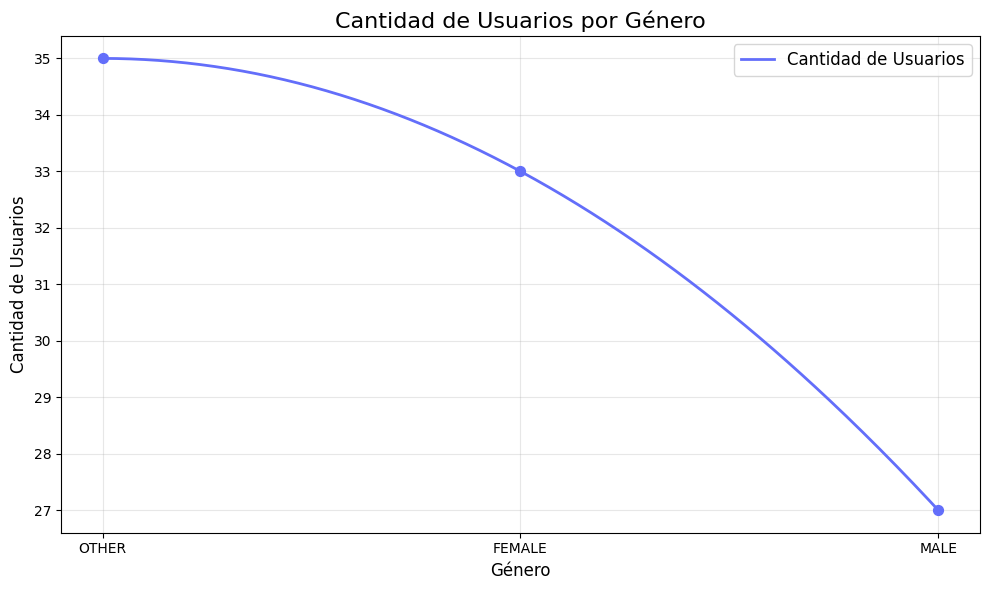

In [75]:
# Calcular la cantidad de usuarios por género
gender_counts = df_users['gender'].value_counts().reset_index()
gender_counts.columns = ['gender', 'count']  # Renombrar columnas para claridad

# Crear valores numéricos para los géneros (eje X)
x = np.arange(len(gender_counts))  # [0, 1, 2, ...]
y = gender_counts['count'].values  # Cantidades de usuarios

# Crear interpolación para suavizar la línea
x_smooth = np.linspace(x.min(), x.max(), 300)  # Puntos más densos en X
y_smooth = make_interp_spline(x, y, k=2)(x_smooth)  # Interpolación cúbica (k=2)

# Crear el gráfico con Matplotlib
plt.figure(figsize=(10, 6))
plt.plot(x_smooth, y_smooth, color="#636EFA", label="Cantidad de Usuarios", linewidth=2)  # Línea suavizada
plt.scatter(x, y, color="#636EFA", s=50, zorder=5)  # Marcadores en los puntos originales

# Personalizar etiquetas y diseño
plt.title("Cantidad de Usuarios por Género", fontsize=16)
plt.xlabel("Género", fontsize=12)
plt.ylabel("Cantidad de Usuarios", fontsize=12)
plt.xticks(ticks=x, labels=gender_counts['gender'], fontsize=10)  # Etiquetas de los géneros en X
plt.grid(alpha=0.3)  # Líneas de la cuadrícula
plt.legend(fontsize=12)

# Mostrar el gráfico
plt.tight_layout()
plt.show()


In [76]:
# Calcular la edad en años

# Convertir 'birth_date' a formato datetime
df_users['birth_date'] = pd.to_datetime(df_users['birth_date'], errors='coerce')

today = datetime.today()
df_users['age'] = df_users['birth_date'].apply(lambda x: today.year - x.year if pd.notnull(x) else None)

# Filtrar filas válidas (solo edades calculadas)
df_users_cleaned = df_users[['age']].dropna().reset_index(drop=True)  # Solo columna 'age'


Se genera un archivo json con los datos del gráfico para su posterior consumo en el frontend

In [77]:
# Crear puntos para densidad
ages = df_users_cleaned['age']
density, bins = np.histogram(ages, bins=30, density=True)

# Crear un diccionario con los datos
data_for_json = {
    "x": bins[:-1].tolist(),  # Bordes izquierdos de cada bin
    "y": density.tolist(),    # Densidad
    "title": "Densidad por Edad de los Pacientes",
    "xaxis_title": "Edad (años)",
    "yaxis_title": "Densidad"
}

# Guardar en un archivo JSON
with open("density_age_distribution.json", "w") as f:
    json.dump(data_for_json, f, indent=4)

print("Datos de densidad guardados en 'density_age_distribution.json'")


Datos de densidad guardados en 'density_age_distribution.json'


Calculo de la edad de cada paciente para calcular tendencias

In [78]:
# Calcular la edad en años

today = datetime.today()
df_users['age'] = df_users['birth_date'].apply(lambda x: today.year - x.year if pd.notnull(x) else None)

# Filtrar filas válidas (solo edades calculadas)
df_users_cleaned = df_users[['age']].dropna().reset_index(drop=True)  # Solo columna 'age'

Visualización gráfica de la densidad por edad de los pacientes 

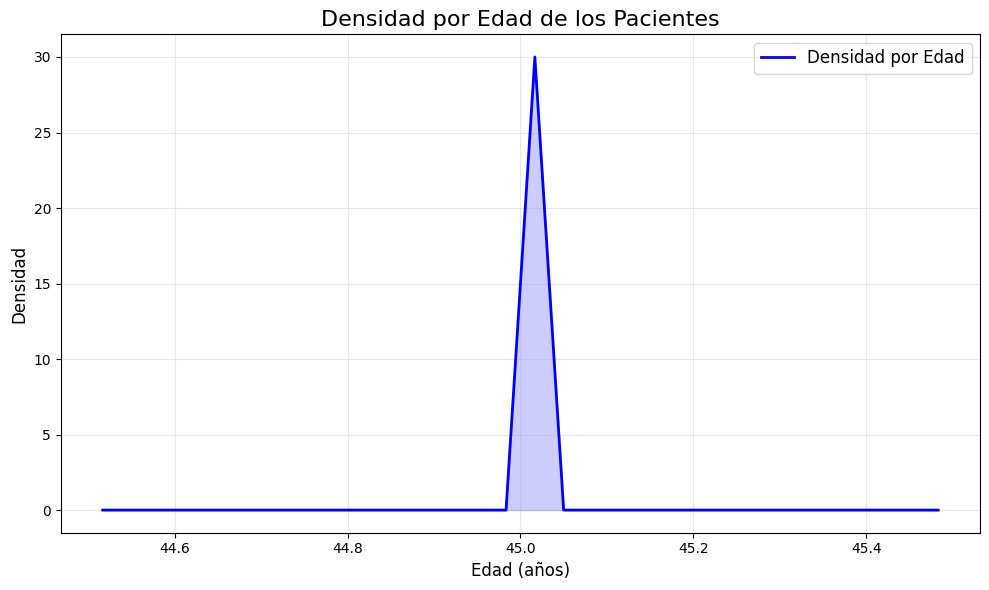

In [79]:
# Extraer los valores de 'age'
ages = df_users_cleaned['age']

# Calcular densidad y bins con numpy.histogram
density, bins = np.histogram(ages, bins=30, density=True)

# Calcular el centro de los bins
x = bins[:-1] + np.diff(bins) / 2  # Centro de cada bin

# Crear el gráfico de densidad
plt.figure(figsize=(10, 6))
plt.plot(x, density, color='blue', label='Densidad por Edad', linewidth=2)
plt.fill_between(x, density, color='blue', alpha=0.2)  # Rellenar debajo de la curva

# Personalización del gráfico
plt.title("Densidad por Edad de los Pacientes", fontsize=16)
plt.xlabel("Edad (años)", fontsize=12)
plt.ylabel("Densidad", fontsize=12)
plt.grid(alpha=0.3)  # Agregar líneas de cuadrícula tenues
plt.legend(fontsize=12)

# Mostrar el gráfico
plt.tight_layout()
plt.show()


Visualización gráfica de la distribución por edad de los pacientes 

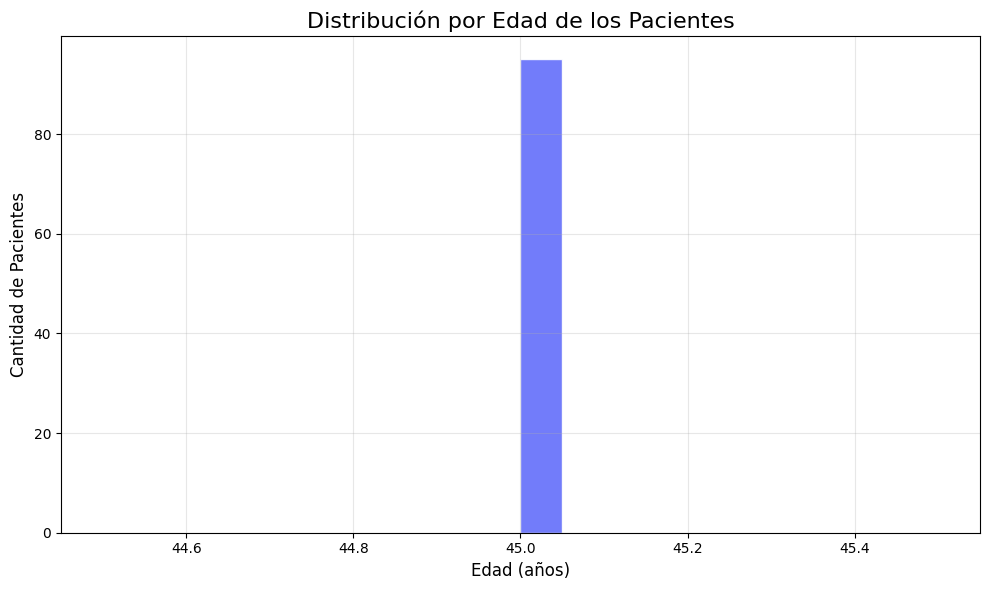

In [80]:
#Gráfico de distribución etaria

# Crear histograma con Matplotlib
plt.figure(figsize=(10, 6))
plt.hist(
    df_users_cleaned['age'],       # Columna de edad
    bins=20,                      # Número de bins (barras)
    color="#636EFA",              # Color de las barras
    edgecolor="white",            # Bordes blancos para las barras
    alpha=0.9                     # Transparencia
)

# Personalizar el diseño del gráfico
plt.title("Distribución por Edad de los Pacientes", fontsize=16)
plt.xlabel("Edad (años)", fontsize=12)
plt.ylabel("Cantidad de Pacientes", fontsize=12)
plt.grid(alpha=0.3)  # Líneas de la cuadrícula tenues

# Mostrar el gráfico
plt.tight_layout()
plt.show()



Se genera un archivo json con los datos del gráfico para su posterior consumo en el frontend

In [81]:
# Calcular datos del histograma
age_bins = pd.cut(df_users_cleaned['age'], bins=10, right=False, include_lowest=True)  # Binificación
age_counts = age_bins.value_counts(sort=False)  # Contar frecuencias en cada bin

# Crear un diccionario con los datos del histograma
data_for_json = {
    "x": [f"{int(interval.left)}-{int(interval.right)}" for interval in age_counts.index],  # Rango de edades
    "y": age_counts.tolist(),  # Cantidad en cada bin
    "title": "Distribución por Edad de los Pacientes",
    "xaxis_title": "Edad (años)",
    "yaxis_title": "Cantidad de Pacientes"
}

# Guardar datos en un archivo JSON
with open("histogram_age_distribution.json", "w") as f:
    json.dump(data_for_json, f, indent=4)

print("Datos del histograma guardados en 'histogram_age_distribution.json'")


Datos del histograma guardados en 'histogram_age_distribution.json'


Se calcula la frecuencia de las visitas por paciente

In [82]:
frequency = df_users.groupby("_id").size().reset_index(name="visit_frequency")
df_users = df_users.merge(frequency, on="_id", how="left")


Visualización de la frecuencia de visitas por paciente

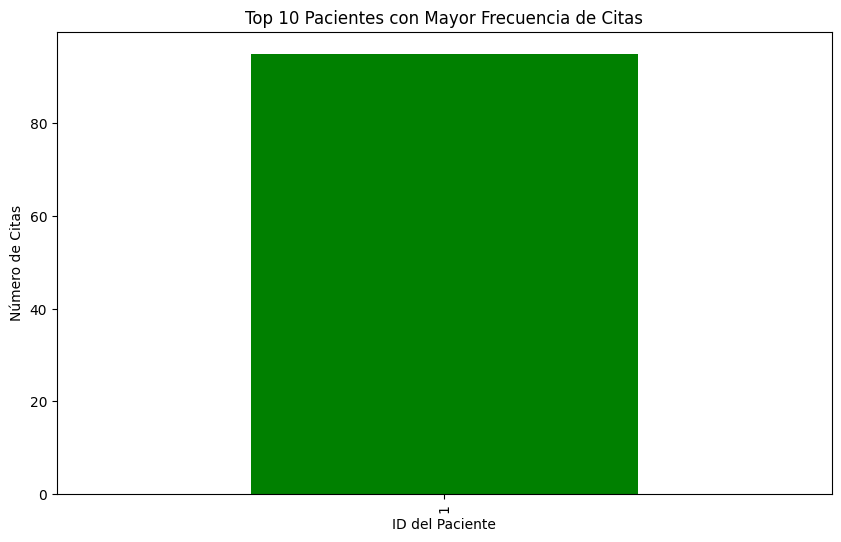

In [83]:
top_patients = df_users["visit_frequency"].value_counts().head(10)
top_patients.plot(kind="bar", figsize=(10, 6), color="green")
plt.title("Top 10 Pacientes con Mayor Frecuencia de Citas")
plt.xlabel("ID del Paciente")
plt.ylabel("Número de Citas")
plt.show()


Inspección de la colección "appointments"

In [84]:
# Ver los primeros registros del DataFrame

#df_appointments.head()

In [85]:
#Chequeo de valores nulos y tipo de datos

df_appointments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   _id                  4 non-null      object        
 1   name                 4 non-null      object        
 2   contact_id           4 non-null      object        
 3   location             4 non-null      object        
 4   start_time           4 non-null      datetime64[ns]
 5   end_time             4 non-null      datetime64[ns]
 6   appointment_type_id  4 non-null      object        
 7   short_description    4 non-null      object        
 8   notes                4 non-null      object        
 9   confirmed            4 non-null      bool          
 10  cancelled            4 non-null      bool          
 11  completed            4 non-null      bool          
 12  broken               4 non-null      bool          
 13  doctor_id            4 non-null      ob

In [86]:
# Contar la cantidad de citas por tipo

df_appointments['appointment_type_id'].value_counts()

appointment_type_id
f6a2acce-04be-46bd-ad43-3ec97b16af43    4
Name: count, dtype: int64

In [87]:
# Contar las citas por ubicación

df_appointments['location'].value_counts()

location
Santiago        2
Lima            1
Buenos Aires    1
Name: count, dtype: int64

In [88]:
# Analizar las citas por estado (confirmadas, canceladas, completadas, etc.)

appointment_status = df_appointments[['confirmed', 'cancelled', 'completed', 'broken']].sum()
print(appointment_status)

confirmed    1
cancelled    0
completed    1
broken       0
dtype: int64


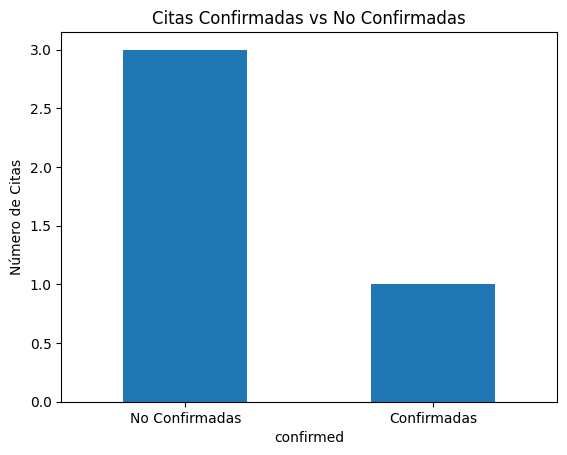

In [89]:
# Ver la distribución de las citas confirmadas vs no confirmadas


df_appointments['confirmed'].value_counts().plot(kind='bar', title='Citas Confirmadas vs No Confirmadas')
plt.ylabel('Número de Citas')
plt.xticks(ticks=[0, 1], labels=['No Confirmadas', 'Confirmadas'], rotation=0)
plt.show()

Análisis temporal (fecha y hora de las citas)

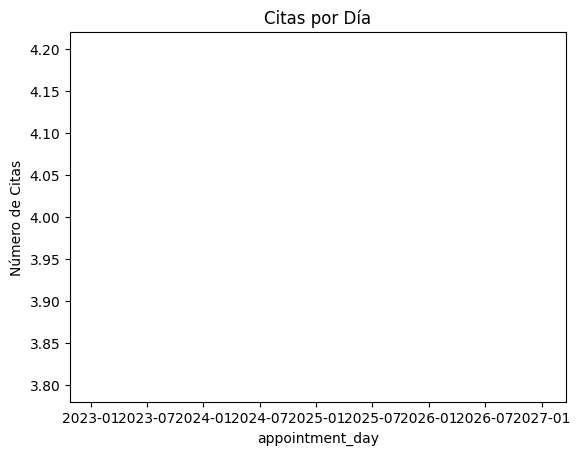

In [90]:
# Extraer fecha y hora

df_appointments['appointment_day'] = df_appointments['start_time'].dt.date
df_appointments['appointment_hour'] = df_appointments['start_time'].dt.hour

# Distribución de citas por día

appointments_by_day = df_appointments['appointment_day'].value_counts().sort_index()
appointments_by_day.plot(kind='line', title='Citas por Día')
plt.ylabel('Número de Citas')
plt.show()


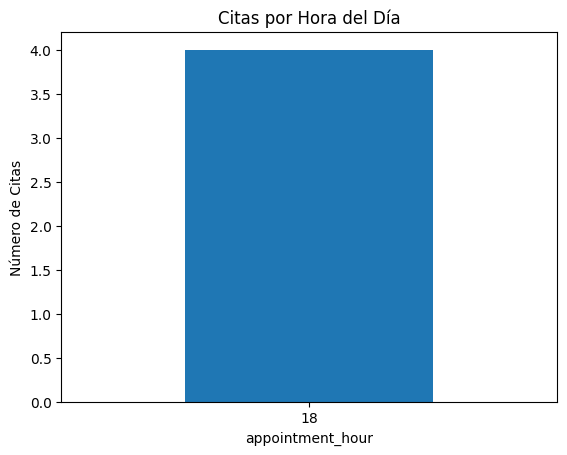

In [91]:
# Distribución de citas por hora del día

appointments_by_hour = df_appointments['appointment_hour'].value_counts().sort_index()
appointments_by_hour.plot(kind='bar', title='Citas por Hora del Día')
plt.ylabel('Número de Citas')
plt.xticks(rotation=0)
plt.show()

Análisis de la duración de las citas

count    4.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0
Name: duration, dtype: float64


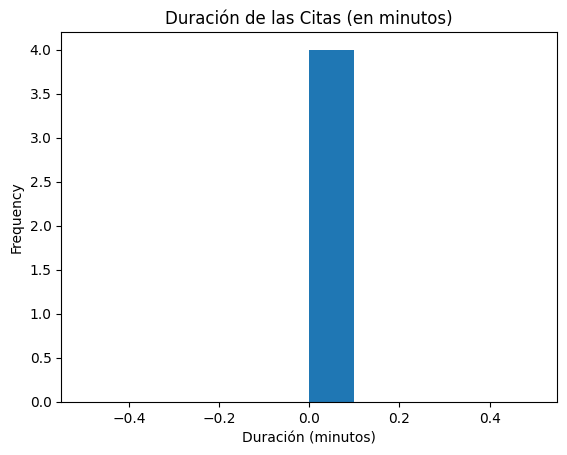

In [92]:
# Calcular la duración de cada cita
df_appointments['duration'] = (df_appointments['end_time'] - df_appointments['start_time']).dt.total_seconds() / 60

# Estadísticas descriptivas de la duración
print(df_appointments['duration'].describe())

# Histograma de la duración de las citas
df_appointments['duration'].plot(kind='hist', bins=10, title='Duración de las Citas (en minutos)')
plt.xlabel('Duración (minutos)')
plt.show()

Análisis de citas por doctor

doctor_id
6baaea4a-d848-4b72-ac16-cc5f53612f23    4
Name: count, dtype: int64


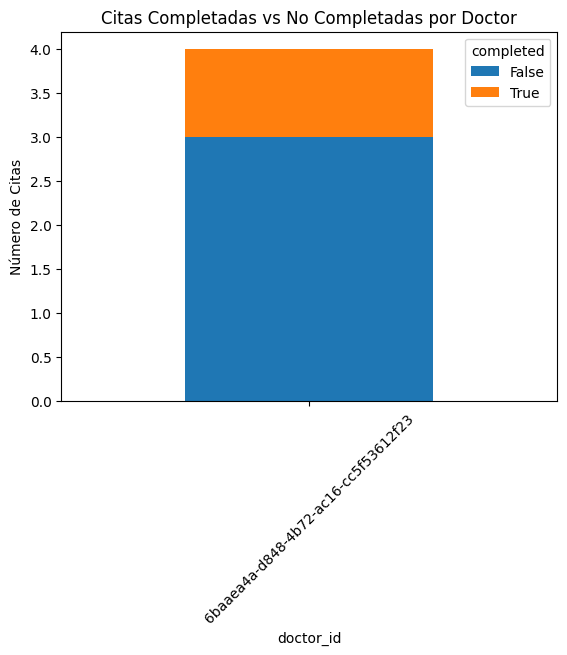

In [93]:
# Número de citas por doctor
appointments_by_doctor = df_appointments['doctor_id'].value_counts()
print(appointments_by_doctor)

# Citas completadas vs no completadas por doctor
appointments_by_doctor_status = df_appointments.groupby('doctor_id')['completed'].value_counts().unstack()
appointments_by_doctor_status.plot(kind='bar', stacked=True, title='Citas Completadas vs No Completadas por Doctor')
plt.ylabel('Número de Citas')
plt.xticks(rotation=45)
plt.show()


Análisis de citas canceladas

In [94]:
# Analizar las citas canceladas
cancelled_appointments = df_appointments[df_appointments['cancelled'] == True]

# Ver qué tipo de citas son las más canceladas
cancelled_by_type = cancelled_appointments['appointment_type_id'].value_counts()
print(cancelled_by_type)

# Ver citas canceladas por doctor
cancelled_by_doctor = cancelled_appointments['doctor_id'].value_counts()
print(cancelled_by_doctor)

# Ver citas canceladas por ubicación
cancelled_by_location = cancelled_appointments['location'].value_counts()
print(cancelled_by_location)


Series([], Name: count, dtype: int64)
Series([], Name: count, dtype: int64)
Series([], Name: count, dtype: int64)


In [95]:
#df_appointments.head()

### Predicción del Riesgo de Abandono (Churn)

Se utiliza un modelo predictivo basado en **RandomForestClassifier** para estimar el riesgo de abandono de los pacientes. La predicción se realiza considerando el tiempo transcurrido desde su última cita como variable principal.


In [96]:
# Preprocesamiento de datos

# Convertir columnas de tiempo a formato datetime
df_appointments['start_time'] = pd.to_datetime(df_appointments['start_time'], errors='coerce')
df_appointments['end_time'] = pd.to_datetime(df_appointments['end_time'], errors='coerce')

# Crear características adicionales
df_appointments['appointment_duration'] = (df_appointments['end_time'] - df_appointments['start_time']).dt.total_seconds() / 60
df_appointments['appointment_day'] = df_appointments['start_time'].dt.dayofweek
df_appointments['appointment_hour'] = df_appointments['start_time'].dt.hour

# Crear la variable objetivo (churn)
# Definimos churn como aquellos pacientes que no han tenido citas en los últimos 6 meses
cutoff_date = datetime.today() - pd.DateOffset(months=6)
df_appointments['churn'] = df_appointments['start_time'] < cutoff_date

# Agrupar por paciente y calcular características agregadas
patient_features = df_appointments.groupby('_id').agg({
    'appointment_duration': ['mean', 'sum'],
    'appointment_day': 'nunique',
    'appointment_hour': 'nunique',
    'churn': 'max'
}).reset_index()

# Renombrar columnas
patient_features.columns = ['_id', 'mean_duration', 'total_duration', 'unique_days', 'unique_hours', 'churn']

# Dividir los datos en conjuntos de entrenamiento y prueba
X = patient_features.drop(columns=['_id', 'churn'])
y = patient_features['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluar el modelo
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1



### Segmentación de Pacientes

Este análisis utiliza **K-Means**, un algoritmo de clustering no supervisado, para segmentar a los pacientes en función de su **edad** y **frecuencia de visitas**. 

- **Tipo de segmentación:** No supervisada, cuantitativa, basada en similitudes (distancia Euclidiana).
- **Objetivo:** Identificar grupos con patrones similares, como:
  - Pacientes jóvenes con visitas frecuentes.
  - Pacientes mayores con visitas ocasionales.
  - Pacientes de mediana edad con visitas moderadas.

#### **Aplicaciones:**
- Personalizar estrategias de marketing.
- Optimizar recursos y horarios.
- Analizar comportamientos y patrones de los pacientes.


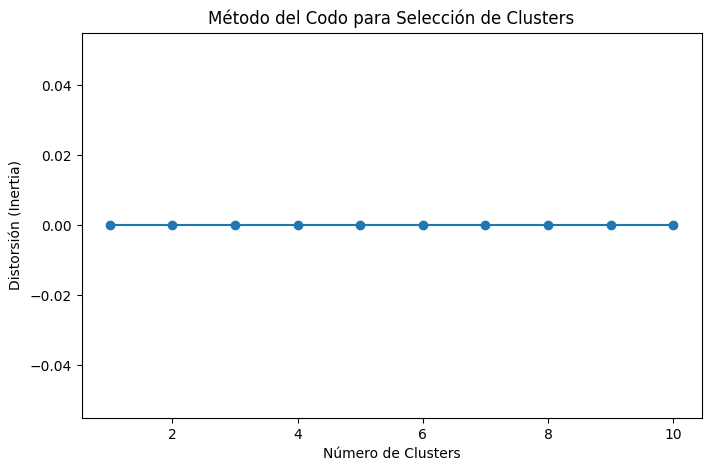

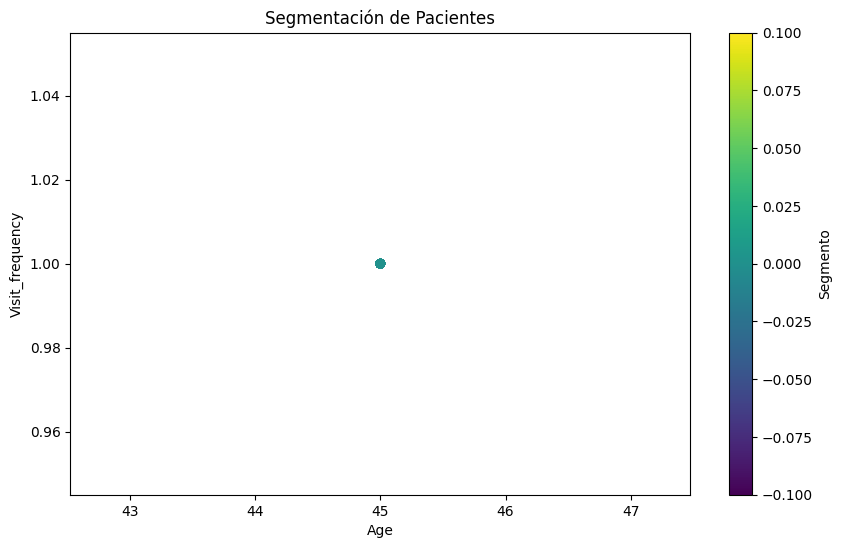

In [97]:
def preprocess_data(df, columns):
    # Verificar columnas y eliminar filas con valores nulos
    if not all(col in df.columns for col in columns):
        raise ValueError(f"Las columnas {columns} no existen en el dataframe.")
    features = df[columns].dropna()
    return features

def find_optimal_clusters(data, max_clusters=10):
    """Usa el método del codo para determinar el número óptimo de clusters."""
    distortions = []
    for k in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(data)
        distortions.append(kmeans.inertia_)
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, max_clusters + 1), distortions, marker='o')
    plt.xlabel('Número de Clusters')
    plt.ylabel('Distorsión (Inertia)')
    plt.title('Método del Codo para Selección de Clusters')
    plt.show()

def cluster_and_visualize(df, features, n_clusters=3):
    # Normalización
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    # Entrenamiento del modelo KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(scaled_features)

    # Crear una copia de los índices para evitar desalineación
    aligned_indices = features.index

    # Asignación de segmentos
    df.loc[aligned_indices, 'segment'] = kmeans.labels_

    # Visualización de los segmentos
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(df.loc[aligned_indices, features.columns[0]], 
                          df.loc[aligned_indices, features.columns[1]], 
                          c=df.loc[aligned_indices, 'segment'], cmap='viridis')
    plt.xlabel(features.columns[0].capitalize())
    plt.ylabel(features.columns[1].capitalize())
    plt.title('Segmentación de Pacientes')
    plt.colorbar(scatter, label='Segmento')
    plt.show()

# Uso del pipeline mejorado
columns_to_use = ['age', 'visit_frequency']
features = preprocess_data(df_users, columns_to_use)

# Encontrar el número óptimo de clusters
find_optimal_clusters(features)

# Aplicar clustering con un número óptimo de clusters (ajusta según el gráfico del codo)
cluster_and_visualize(df_users, features, n_clusters=3)



In [98]:
# Exportar el DataFrame a CSV

df_users.to_csv("C:/DentalRainMaker/dental_data_pipeline/datasets_BI/users.csv", index=False)
df_appointments.to_csv("C:/DentalRainMaker/dental_data_pipeline/datasets_BI/appointments.csv", index=False)